### Лабораторная работа 2


### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии
- реализуете логистическую регрессию и её обучение градиентным спуском
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными

In [298]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve, roc_curve

Populating the interactive namespace from numpy and matplotlib


C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Часть 1. Линейная регрессия

В этой части мы кратко познакомимся с линейной регрессией.

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3.

In [3]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.



Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$). Согласуются ли результаты с вашими ожиданиями?

In [4]:
# Your code here
# ...
display(data.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [92]:
pd.DataFrame.from_dict(data.data.shape)

,0
0,442
1,10


In [6]:
from sklearn.linear_model import Lasso, Ridge

In [8]:
print("L1:", np.sum(np.abs(Lasso().fit(X_train, y_train).coef_) < 0.001))
print("L2:", np.sum(np.abs(Ridge().fit(X_train, y_train).coef_) < 0.001))

L1: 7
L2: 0


In [58]:
l1, l2 = list(), list()
x = np.logspace(start=-3, stop=3, num=1000)
for alpha in x:
    temp = (Lasso(alpha).fit(X_train, y_train),Ridge(alpha).fit(X_train, y_train))
    l1.append(np.sum(np.abs(temp[0].coef_) > 0.001))
    l2.append(np.sum(np.abs(temp[1].coef_) > 0.001))

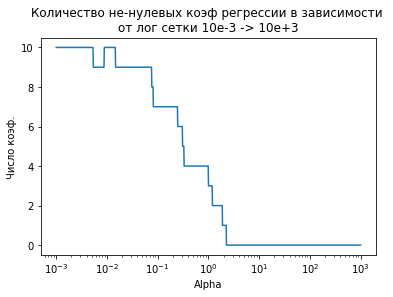

In [61]:
plt.title("Количество не-нулевых коэф регрессии в зависимости \nот лог сетки 10e-3 -> 10e+3")
plt.semilogx(x, l1, color='tab:blue')
plt.xlabel("Alpha")
plt.ylabel("Число коэф.")
plt.show()

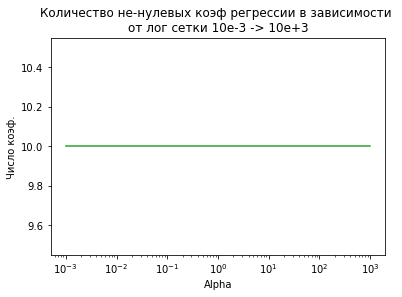

In [62]:
plt.semilogx(x, l2, color='tab:green')
plt.xlabel("Alpha")
plt.ylabel("Число коэф.")
plt.title("Количество не-нулевых коэф регрессии в зависимости \nот лог сетки 10e-3 -> 10e+3")
plt.show()

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [83]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [84]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

RMSE: 58.304415127748044
MAE: 49.60284607275299
R^2: 0.3598993868368464


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Для этого воспользуйтесь GridSearchCV и KFold из sklearn. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

In [67]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [89]:
metrics = ('neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error')
cv = KFold(n_splits=5, random_state=52, shuffle=True)
message : str = str()

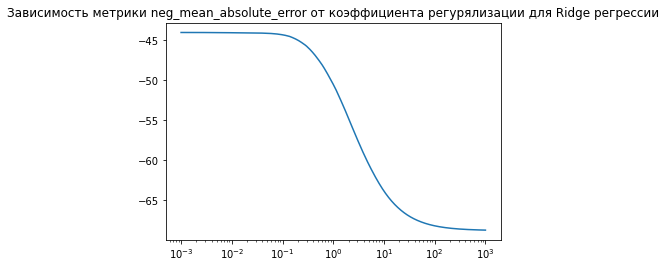

Лучший результат по метрике neg_mean_absolute_error коэф. регулизации 0.0021102034285685966

RMSE: 55.81834632917511
MAE: 47.12111505858874
R^2: 0.41332269428072554
--------------------------


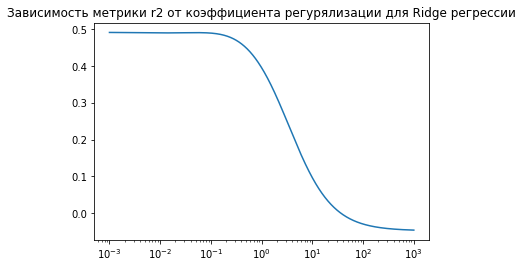

Лучший результат по метрике r2 коэф. регулизации 0.001

RMSE: 55.85776764051341
MAE: 47.15555064391418
R^2: 0.41249372828323017
--------------------------


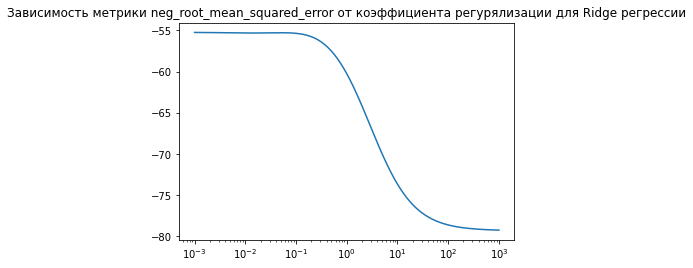

Лучший результат по метрике neg_root_mean_squared_error коэф. регулизации 0.001

RMSE: 55.85776764051341
MAE: 47.15555064391418
R^2: 0.41249372828323017
--------------------------


In [91]:
for metric in metrics:
    gs = GridSearchCV(Ridge(), {'alpha': x}, cv=cv, scoring=metric)
    gs.fit(X_train, y_train)
    message = "Лучший результат по метрике {metric} коэф. регулизации {s}\n".format(s=gs.best_params_["alpha"], metric=metric)
    scores = gs.cv_results_['mean_test_score']
    plt.title(f'Зависимость метрики {metric} от коэффициента регурялизации для Ridge регрессии')
    plt.semilogx(gs.cv_results_['param_alpha'].data, scores)
    plt.show()
    print(message)

    model = Ridge(alpha=gs.best_params_["alpha"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))
    print("--------------------------")

__Задание 2.__ Поиск объектов-выбросов



Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. С помощью cross_val_predict сделайте Out-of-Fold предсказания для обучающей выборки. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

In [124]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(Ridge(0.001), X_train, y_train, cv=cv)

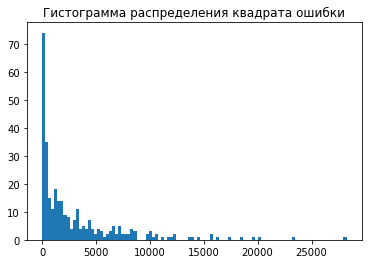

In [125]:
plt.title('Гистограмма распределения квадрата ошибки')
plt.hist((y_train - y_pred)**2, bins = 100)
plt.show()

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [134]:
model = Ridge(alpha=0.001)
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)

rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
mae1 = mean_absolute_error(y_test, y_pred1)
r21 = r2_score(y_test, y_pred1)

In [139]:
slices = (y_train - y_pred)**2 < 20000
X_train_new = X_train[slices]
y_train_new = y_train[slices]

In [140]:
model_new = Ridge(alpha=0.001)
model_new.fit(X_train_new, y_train_new)
y_pred_new = model_new.predict(X_test)

In [141]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))
mae = mean_absolute_error(y_test, y_pred_new)
r2 = r2_score(y_test, y_pred_new)

In [142]:
print(f"Оригинал - RMSE: {rmse1}. MAE: {mae1}. R2: {r21}.")
print(f"Без 'вбросов' - RMSE: {rmse}. MAE: {mae}. R2: {r2}.")

Оригинал - RMSE: 55.85776764051341. MAE: 47.15555064391418. R2: 0.41249372828323017.
Без 'вбросов' - RMSE: 56.04669519262224. MAE: 47.150272586650914. R2: 0.40851276601504005.


## Часть 2. Логистическая регрессия

В этой части мы будем реализовывать один из самых простых бинарных классификаторов — логистическую регрессию и её обучение с помощью обычного (полного) и стохастического градиентных спусков.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). В случае стохастического градиентного спуска $\nabla_w Q(w, X) \approx \nabla_w q_{i_k} (w)$, где $i_k$ — случайно выбранный номер слагаемого из функционала (регуляризатор можно внести в сумму, предварительно умножив и разделив на $l$). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Формулу для градиента функции потерь логистической регрессии вы должны были выводить в рамках одной из задач четвёртого теоретического домашнего задания. Но на всякий случай мы её повторим. Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Вероятность принадлежности объекта $x$ классу $+1$ вычисляется следующим образом:

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- \langle w, x \rangle )}
$$

Не забывайте, что матрицу объекты-признаки $X$ необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из 2 способов, разобранных на лекциях). Для этого можно воспользоваться StandardScaler или сделать это вручную.

В логистической регрессии также можно использовать $L_1$-регуляризацию. Тогда в функцию потерь добавится слагаемое $\lambda_1 \lVert w \rVert _1$. В формуле для вычисления градиента фукнции потерь по вектору коэффициентов это слагаемое будет соответствовать $\lambda_1 sgn(w)$, где $sgn$ — вычисление знака числа, применяемое к вектору коэффициентов поэлементо.

__Задание 1.__ Реализация обучения и применения логистической регресии c $L_2$-регуляризацией. 



Используйте для этого указанные ниже прототипы. Для эффективности все вычисления производите в векторизованной форме без циклов (кроме самих итераций градиентного спуска). Сгенерируйте с помощью функции make\_classification из модуля sklearn.datasets небольшую выборку для тестирования и исследования (выборка не должна быть слишком простой для классификации; также не забудьте проверить, что метки объектов из необходимого нам множества). Постройте следующие графики (для полного и стохастического градиентного спуска на одном графике):
- функции потерь от номера итерации обучения
- затраченного времени от номера итерации обучения

Возьмите параметр регуляризации $\lambda_2=1$, точность $tolerance=10^{-6}$, максимальное число итераций $max\_iter=1000$. Подберите оптимальную на ваш взгляд величину шага градиентного спуска. 

Сделайте выводы о том, чем различается на практике обучение с помощью стохастического градиентного спуска по сравнению с полным градиентным спуском.

В этом задании не обращайте внимания на $\lambda_1$, соответствующий $L_1$-регуляризации.

Для численной устойчивости вам могут быть полезны функции: scipy.special.expit и numpy.logaddexp.

__Важно:__ код с реализацией логистической регрессии необходимо также отправить на проверку в Яндекс.контест (ссылка [раз](https://official.contest.yandex.ru/contest/5704/problems/) и [альтернативная](https://contest.yandex.ru/contest/5704/problems/)). Не забывайте про pep8. 

ID посылки: ...

__Бонусное задание.__ Реализация $L_1$-регуляризации и обучение с помощью субградиентного спуска.

__(1.0 балла)__

Модифицируйте реализацию так, чтобы можно было обучать логистическиую регрессию с $L_1$-регуляризацией (и даже одновременно с двумя видами). Проведите аналогичные эксперименты, считая $\lambda_1 = 0.001, \lambda_2 = 0$.

Стоит помнить, что модуль — недифференцируемая в нуле функция, поэтому мы не можем применить обычный градиентный спуск. Вместо этого будем применить субградиентный спуск — аналогичный градиентному спуску метод, в котором используется субградиент функции. 

Вектор $g \in \mathbb{R}$ называется субградиентом выпуклой функции $f$ в точке $x$, если $\forall z \in \mathbb{R}$ выполнено неравенство: $f(z) \ge f(x) + g^T (z-x)$. Если функция $f$ дифференцируема в точке $x$, её субградиент в этой точке совпадает с градиентом. Субдифференциалом функции $f$ называют множество субградиентов в этой точке.

Для $f(x) = |x|$ при $x = 0$ субдифференциал определяется неравенством $|z| \ge gz$, поэтому $g \in [-1, 1]$. 

На практике для стабильности процесса обучения для близких к нулю значений можно уменьшать градиент, умножая на небольшое число (например, 0.1-0.5) или делая его нулевым (только околонулевые координаты!)

In [366]:
from time import time
from scipy.special import expit
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic',
                 tolerance=1e-6, max_iter=1000, w0=None, alpha=1e-3,
                 random_state=None
                ):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = None
        self.time_history = None
        self.random_state = random_state
        self.temp1 = 0
        self.temp2 = 0

    def fit(self, X, y, X_val=None, y_val=None, calc_loss=False):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        self.time_history = []


        np.random.seed(self.random_state)
        self.w = self.w0 if self.w0 is not None else np.random.uniform(0, 1e-6, size=(X.shape[1]))

        start = time()

        for i in range(self.max_iter):
            current_loss = self.calc_loss(X, y)
            old_w = self.w.copy()
            #self.temp1 +=1
            if self.gd_type == "stochastic":
                #i_k = np.random.randint(0, l, size=(1, ))
                #g = self.calc_gradient(X[i_k, :], y[i_k])
                mask_size = X.shape[0] // 100
                if mask_size < 1:
                    mask_size = 1
                mask = np.random.choice(X.shape[0], size=mask_size, replace=False)
                mask = sorted(mask)
                g = self.calc_gradient(X[mask, :], y[mask])
            else:
                g = self.calc_gradient(X, y)

            self.w -= g * self.alpha
            self.loss_history.append(current_loss)
            self.time_history.append([time() - start])

            if abs(np.linalg.norm(self.w - old_w)) <= self.tolerance:
                break
            #self.temp2 += 1
        return self

    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')

        result = 1 / (1 + np.exp(-X.dot(self.w)))
        return np.hstack([1 - result.reshape([-1, 1]), result.reshape([-1, 1])])

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        #g = -y[:, np.newaxis] * X * expit(-y * X.dot(self.w))[:, np.newaxis]
        #return g.mean(axis=0) + self.lambda_2 * self.w
        return np.dot(X.T, -expit(-y * X.dot(self.w)) * y) / X.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float
        """
        #return np.mean(np.log(1 + np.exp(-y * (np.dot(X, self.w))))) +\
               #self.lambda_2 / 2 * np.dot(self.w, self.w)
        return (np.logaddexp(0, -y * X.dot(self.w)).mean() +
                self.lambda_2 / 2.0 * np.sum(self.w ** 2))

In [282]:
Xc, yc = make_classification(n_samples=5000, n_features=100, n_informative=25, n_redundant=5,
                             random_state=1, class_sep=0.5, shift=0)

scaler = StandardScaler()
Xcc = Xc.copy()
ycc = yc.copy()
Xcc = np.hstack([np.ones((Xc.shape[0], 1)), Xc])
scaler.fit(Xcc)
Xcc = scaler.transform(Xcc)

lr_full = LogReg(gd_type="full")
lr_full.fit(Xcc, ycc)
y_pred = lr_full.predict_proba(Xcc)[:, 1]
print('full', roc_auc_score(ycc, y_pred))

lr_sto = LogReg(gd_type="stochastic")
lr_sto.fit(Xcc, ycc)
y_pred = lr_sto.predict_proba(Xcc)[:, 1]
print('stochastic', roc_auc_score(ycc, y_pred))


lr_sklearn = LogisticRegression(max_iter=1000,tol=1e-6)
lr_sklearn.fit(Xc, yc)
y_pred = lr_sklearn.predict_proba(Xc)[:, 1]
print('LogisticRegression', roc_auc_score(yc, y_pred))

lr_bonus = LogReg(gd_type="stochastic", alpha=0.001, lambda_2=0)
lr_bonus.fit(Xcc, ycc)
y_pred = lr_bonus.predict_proba(Xcc)[:, 1]
print('bonus', roc_auc_score(ycc, y_pred))

full 0.7417657882526121
stochastic 0.7390998255972097
LogisticRegression 0.7855647290356647
bonus 0.7417203475255605


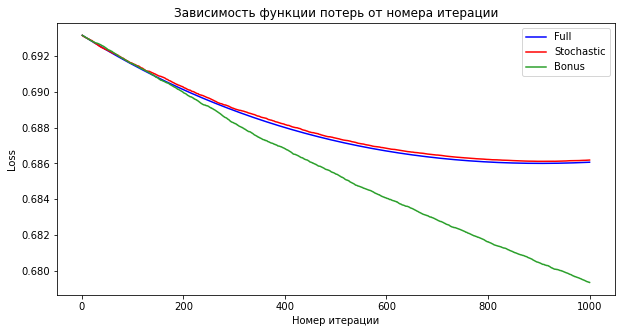

In [283]:
x_full = np.array(range(len(lr_full.loss_history))) + 1
x_sto = np.array(range(len(lr_sto.loss_history))) + 1
x_bonus = np.array(range(len(lr_bonus.loss_history))) + 1
y_full = lr_full.loss_history
y_sto = lr_sto.loss_history
y_bonus = lr_bonus.loss_history
plt.figure(figsize=(10, 5))
plt.title('Зависимость функции потерь от номера итерации')
plt.xlabel('Номер итерации')
plt.ylabel('Loss')
plt.plot(x_full, y_full, 'b', x_sto, y_sto, 'r', x_bonus, y_bonus, 'C2')
plt.legend(['Full', 'Stochastic', 'Bonus'])
plt.show()

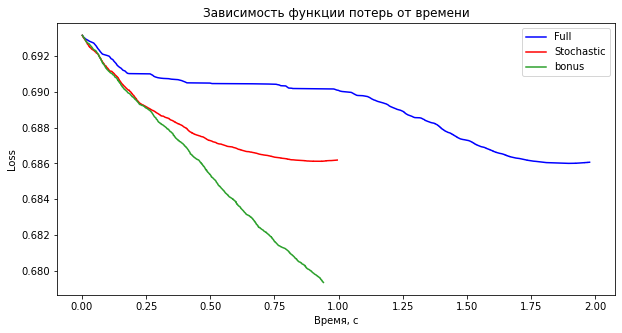

In [289]:
x_full = np.array(lr_full.time_history)
x_sto = np.array(lr_sto.time_history)
x_bonus = np.array(lr_bonus.time_history)
y_full = lr_full.loss_history
y_sto = lr_sto.loss_history
y_bonus = lr_bonus.loss_history
plt.figure(figsize=(10, 5))
plt.title('Зависимость функции потерь от времени')
plt.xlabel('Время, с')
plt.ylabel('Loss')

plt.plot(x_full, y_full, 'b', x_sto, y_sto, 'r', x_bonus, y_bonus, 'C2')
plt.legend(['Full', 'Stochastic', 'bonus'])
plt.show()

__Выводы:__ =З

__Задание 2.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.



Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Загрузим данные с актуального сейчас конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [290]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
data.where("ps_reg_01" == 0)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 783681 to 1320118
Data columns (total 57 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ps_ind_01       200000 non-null  int64  
 1   ps_ind_02_cat   200000 non-null  int64  
 2   ps_ind_03       200000 non-null  int64  
 3   ps_ind_04_cat   200000 non-null  int64  
 4   ps_ind_05_cat   200000 non-null  int64  
 5   ps_ind_06_bin   200000 non-null  int64  
 6   ps_ind_07_bin   200000 non-null  int64  
 7   ps_ind_08_bin   200000 non-null  int64  
 8   ps_ind_09_bin   200000 non-null  int64  
 9   ps_ind_10_bin   200000 non-null  int64  
 10  ps_ind_11_bin   200000 non-null  int64  
 11  ps_ind_12_bin   200000 non-null  int64  
 12  ps_ind_13_bin   200000 non-null  int64  
 13  ps_ind_14       200000 non-null  int64  
 14  ps_ind_15       200000 non-null  int64  
 15  ps_ind_16_bin   200000 non-null  int64  
 16  ps_ind_17_bin   200000 non-null  int64  
 17  ps_i

In [292]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [293]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = np.hstack([np.zeros((X_train.shape[0], 1)), scaler.transform(X_train)])
X_test = np.hstack([np.zeros((X_test.shape[0], 1)), scaler.transform(X_test)])

Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [306]:
lr_sto = LogReg(gd_type='stochastic')
lr_sto.fit(X_train, y_train)
y_pred_lr = lr_sto.predict_proba(X_test)[:, 1]
print('ROC AUC', roc_auc_score(y_test, y_pred_lr))
print('Average precision score', average_precision_score(y_test, y_pred_lr))

ROC AUC 0.6188806329118812
Average precision score 0.603117763860261


In [345]:
print('Confusion matrix')
y_pred_no_prob = [1 if x >= 0.5 else 0 for x in y_pred_lr]
cm_o = confusion_matrix(y_test, y_pred_no_prob)
cm_o

Confusion matrix


array([[31634, 18360],
       [23179, 26827]], dtype=int64)

Постройку ROC-кривую и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

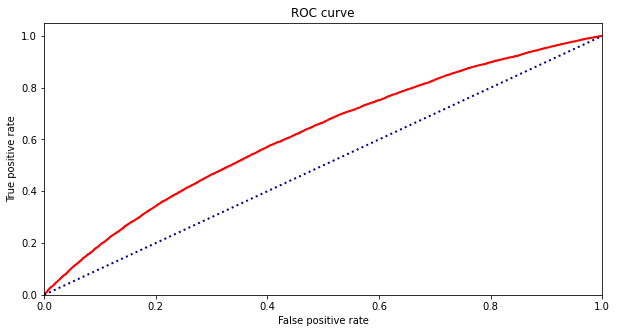

In [325]:
plt.figure(figsize=(10, 5))
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
plt.plot(fpr, tpr, color='red', lw=2, )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

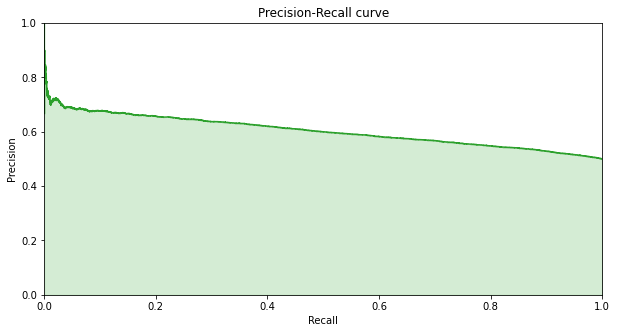

In [323]:
pr_re_curve = precision_recall_curve(y_test, y_pred_lr)
precision, recall, _ = pr_re_curve
plt.figure(figsize = (10, 5))
plt.step(recall, precision, color='C2')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='C2')
plt.show()

Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [352]:
y_score_for_recall, y_pred_for_recall = zip(*sorted(zip(y_pred_lr, y_test), key=lambda _: _[0], reverse=True))
y_score_for_recall = np.array(y_score_for_recall)
y_pred_for_recall = np.array(y_pred_for_recall)
y_pred_cumsum = np.cumsum(y_pred_for_recall == 1)
y_recall = y_pred_cumsum / y_pred_cumsum.max()
threshold = y_score_for_recall[np.where(y_recall >= 0.7)[0][0]]

In [354]:
cm = confusion_matrix(y_test, [1 if x >= threshold else 0 for x in y_pred_lr])
tp, fp = cm[1][1], cm[0][1]

print("CM old")
display(pd.DataFrame(cm_o))
print('Precision', tp/ (tp + fp) )
print('Порог бинаризации для полноты не менее 0.7:', threshold)
print("CM")
cm

CM old


,0,1
0,31634,18360
1,23179,26827


Precision 0.5670986554349587
Порог бинаризации для полноты не менее 0.7: 0.48699342603658186
CM


array([[23271, 26723],
       [14999, 35007]], dtype=int64)

__Задание 3.__ Изучение влияния регуляризатора на процесс обучения



Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [355]:
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xcc, ycc, train_size = 0.7, random_state = 1)

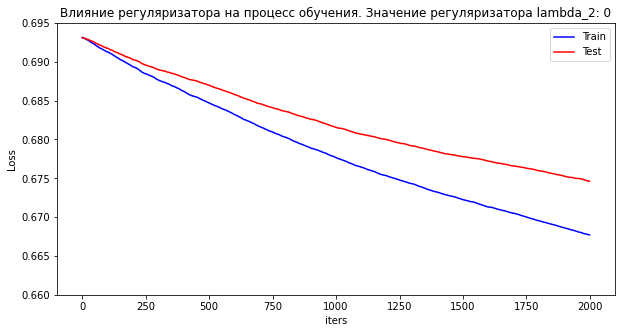

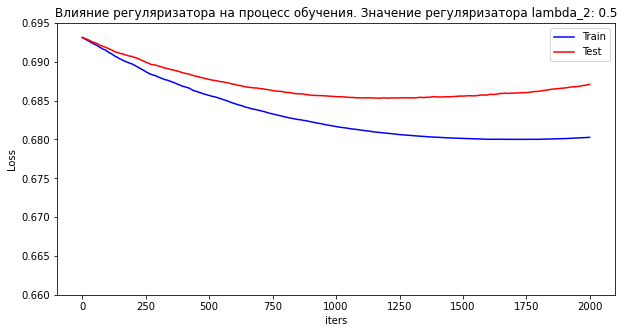

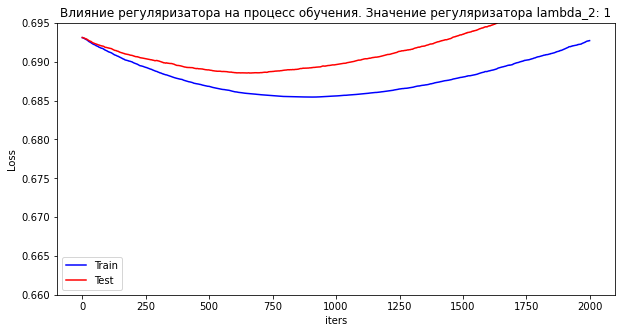

In [368]:
for lambda_2 in [0, 0.5, 1]:
    tr, te = [], []
    w0 = None
    for i in range(2000):
        lr = LogReg(gd_type='stochastic', lambda_2=lambda_2, max_iter = 1, w0 = w0)
        lr.fit(Xo_train, yo_train)
        tr.append(lr.calc_loss(Xo_train, yo_train))
        te.append(lr.calc_loss(Xo_test, yo_test))
        w0 = lr.w
    plt.figure(figsize = (10, 5))
    plt.plot(range(2000), tr, 'b', range(2000), te, 'r')
    plt.title(f'Влияние регуляризатора на процесс обучения. Значение регуляризатора lambda_2: {lambda_2}')
    plt.legend(['Train', 'Test'])
    plt.ylim([0.66, 0.695])
    plt.xlabel('iters')
    plt.ylabel('Loss')
    plt.show()

## Часть 3. Метод опорных векторов и калибровка вероятностней

__Задание 1.__ Обучение и применение метода опорных векторов.



Обучите метод опорных векторов (в этот раз воспользуйтесь готовой реализацией LinearSVC из sklearn). Используйте уже загруженные и обработанные в предыдущей части данные.

In [369]:
from sklearn.svm import LinearSVC

In [387]:
Xj_train, Xj_test, yj_train, yj_test = train_test_split(data, target, train_size=0.7)

scaler = StandardScaler()
scaler.fit(Xj_train)
Xj_train = np.hstack([np.zeros((Xj_train.shape[0], 1)), scaler.transform(Xj_train)])
Xj_test = np.hstack([np.zeros((Xj_test.shape[0], 1)), scaler.transform(Xj_test)])


In [389]:
svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0)
svc.fit(X_train, y_train)

C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=1)

На той же тестовой части посчитайте все те же метрики. Что вы можете сказать о полученных результатах?

Train ROC AUC 0.626140832216428
Test ROC AUC 0.6240357461861148
Train average precision score  0.6138420367585072
Test average precision score  0.6091454448863788


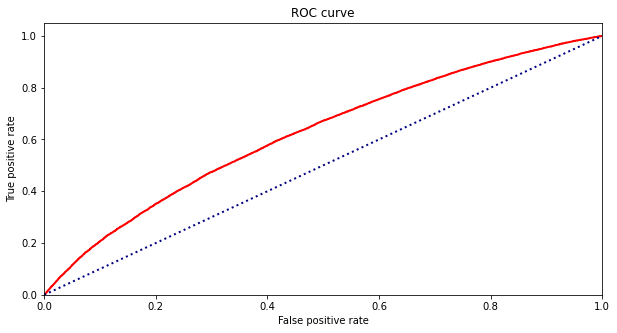

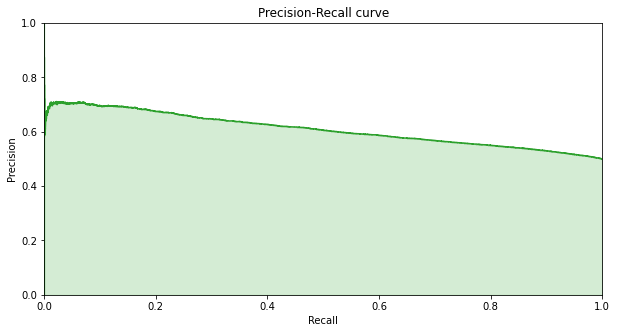

array([[31319, 18675],
       [22566, 27440]], dtype=int64)

In [395]:
y_pred_svc_train = svc.decision_function(X_train)
y_pred_svc = svc.decision_function(X_test)

print('Train ROC AUC', roc_auc_score(y_train, y_pred_svc_train))
print('Test ROC AUC', roc_auc_score(y_test, y_pred_svc))
print('Train average precision score ', average_precision_score(y_train, y_pred_svc_train))
print('Test average precision score ', average_precision_score(y_test, y_pred_svc))

plt.figure(figsize=(10, 5))
fpr, tpr, _ = roc_curve(y_test, y_pred_svc)
plt.plot(fpr, tpr, color='red', lw=2, )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

pr_re_curve = precision_recall_curve(y_test, y_pred_svc)
precision, recall, _ = pr_re_curve
plt.figure(figsize = (10, 5))
plt.step(recall, precision, color='C2')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='C2')
plt.show()

confusion_matrix(y_test, [1 if x > 0 else 0 for x in y_pred_svc])

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов с линейным ядром. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром, так как только в нём есть информация об опорных векторах.

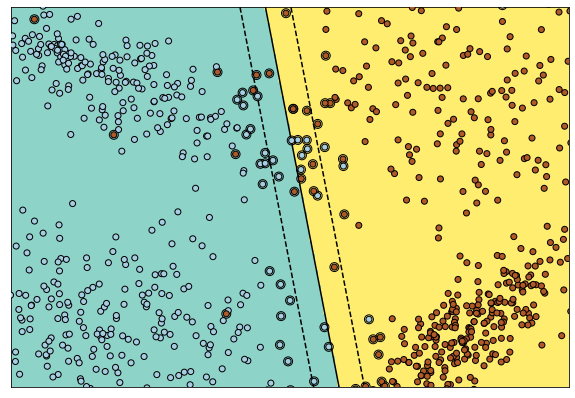

In [409]:
from sklearn import svm


# Our dataset and targets
X, Y = make_classification(n_samples=1000, n_classes=2, n_features=2, n_informative=2,
                           n_repeated=0, n_redundant=0, n_clusters_per_class=2,
                           class_sep = 2.0, random_state = 1)

# fit the model
clf = svm.SVC(kernel="linear", gamma=2)
clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
plt.figure(1, figsize=(10, 7))
plt.clf()

plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
)
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolors="k")

plt.axis("tight")
x_min = -3
x_max = 3
y_min = -3
y_max = 3

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(1, figsize=(10, 7))
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Set3)
plt.contour(
    XX,
    YY,
    Z,
    colors=["k", "k", "k"],
    linestyles=["--", "-", "--"],
    levels=[-0.5, 0, 0.5],
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.show()

__Задание 2.__ Калибровка вероятностей.



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [457]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        if len(y_test[(preds >= l) & (preds < r)] == 1) < 10:
            continue
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.show()
    plt.hist(preds, bins=150)
    plt.show()
    plt.hist(bin_real_ratios, bins=150)
    plt.show()

Посмотройте калибровочные кривые для логистической регрессии и метода опорных векторов (на той же самой выборке с тем же самым разбиением — можно использовать уже полученные ранее предсказания). Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

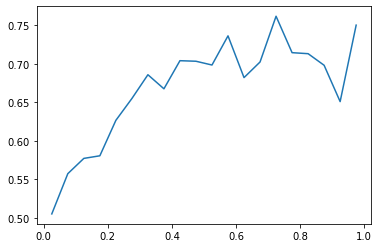

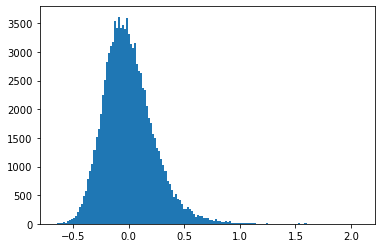

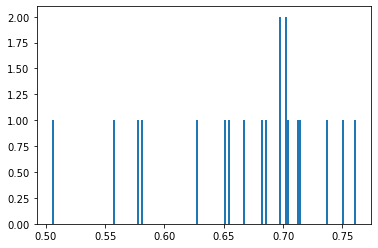

In [458]:
plot_calibration_curve(y_test, y_pred_svc)

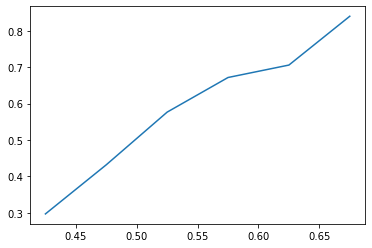

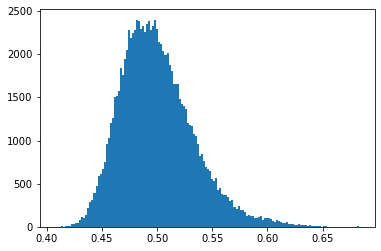

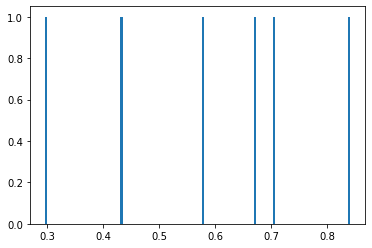

In [459]:
plot_calibration_curve(y_test, y_pred_lr)

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [472]:
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.7)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = np.hstack([np.zeros((X_train.shape[0], 1)), scaler.transform(X_train)])
X_test = np.hstack([np.zeros((X_test.shape[0], 1)), scaler.transform(X_test)])

In [473]:
from sklearn.calibration import CalibratedClassifierCV

C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\leonk\Anaconda3\envs\Neuro\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


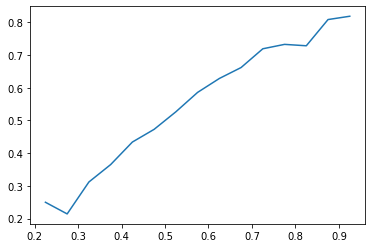

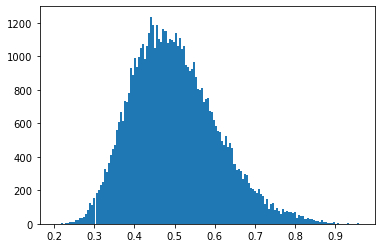

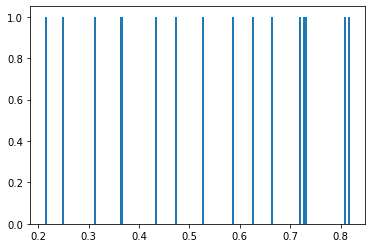

In [474]:
base_estimator = LinearSVC(random_state=42)
calibrated_clf = CalibratedClassifierCV(base_estimator)
calibrated_clf.fit(X_train, y_train)
probs_with_sw = calibrated_clf.predict_proba(X_test)
plot_calibration_curve(y_test, probs_with_sw[:, 1])
        # As the weights are used for the calibration, they should still yield
        # a different predictions

## Часть 4. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.



In [475]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [483]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [484]:
data.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
9,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
13,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
16,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [485]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

def change_values(values):
    change_dict = dict({v: n for n, v in enumerate(sorted(np.unique(values)))})
    values = [change_dict[x] for x in values]
    return values

data_ohe = data[[x for x in data.columns if x.endswith('_cat')]]
data_ohe = data_ohe.apply(lambda x: change_values(x.tolist()), axis = 0)
ohe.fit(data_ohe)
data_ohe = ohe.transform(data_ohe)
data_ohe_dense = pd.DataFrame(data_ohe.todense(),
                              columns = [f'ohe_cat_{x}' for x in range(data_ohe.shape[1])]).astype(int)
data_not_ohe = data.loc[:, [x for x in data.columns if not x.endswith('_cat')]]
data_ohe_dense.index = data_not_ohe.index
data = pd.concat([data_not_ohe, data_ohe_dense], axis = 1)
data.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ohe_cat_173,ohe_cat_174,ohe_cat_175,ohe_cat_176,ohe_cat_177,ohe_cat_178,ohe_cat_179,ohe_cat_180,ohe_cat_181,ohe_cat_182
id,,,,,,,,,,,,,,,,,,,,,
783681,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636497,0,6,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
659813,2,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
334742,0,10,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1156570,0,9,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [488]:
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

def change_values(values):
    change_dict = dict({v: n for n, v in enumerate(sorted(np.unique(values)))})
    values = [change_dict[x] for x in values]
    return values

data_ohe = data[[x for x in data.columns if x.endswith('_bin')]]
data_ohe = data_ohe.apply(lambda x: change_values(x.tolist()), axis = 0)
ohe.fit(data_ohe)
data_ohe = ohe.transform(data_ohe)
data_ohe_dense = pd.DataFrame(data_ohe.todense(),
                              columns = [f'ohe_bin_{x}' for x in range(data_ohe.shape[1])]).astype(int)
data_not_ohe = data.loc[:, [x for x in data.columns if not x.endswith('_bin')]]
data_ohe_dense.index = data_not_ohe.index
data = pd.concat([data_not_ohe, data_ohe_dense], axis = 1)
data.head()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ohe_bin_24,ohe_bin_25,ohe_bin_26,ohe_bin_27,ohe_bin_28,ohe_bin_29,ohe_bin_30,ohe_bin_31,ohe_bin_32,ohe_bin_33
id,,,,,,,,,,,,,,,,,,,,,
341445,2,7,0,0,0.9,1.6,1.874833,3,0.591608,1.753986,...,0,1,0,1,1,0,1,0,1,0
942776,0,0,0,8,0.3,0.0,1.681889,2,0.424264,0.881467,...,1,0,1,0,1,0,1,0,1,0
1360112,5,7,0,11,0.9,0.7,1.213466,3,0.316228,0.652112,...,1,0,0,1,1,0,1,0,1,0
21604,2,4,0,5,0.5,0.4,0.956556,2,0.316228,0.577147,...,0,1,0,1,0,1,0,1,1,0
1218236,0,1,0,6,0.4,0.0,0.581485,2,0.424264,0.851627,...,0,1,1,0,0,1,0,1,1,0


In [489]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [491]:
lm = LogisticRegression(max_iter=20000)
lm.fit(X_train, y_train)

y_pred = lm.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC на выборке с One Hot encoding: {auc}')

ROC AUC на выборке с One Hot encoding: 0.6302533776369643


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?



In [492]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [496]:
cat_cols = [x for x in data.columns if x.endswith('_cat')]
data[cat_cols].head()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
id,,,,,,,,,,,,,,
7,2,1,0,10,1,-1,0,1,4,1,0,0,1,12
9,1,0,0,11,1,-1,0,-1,11,1,1,2,1,19
13,4,1,0,7,1,-1,0,-1,14,1,1,2,1,60
16,1,0,0,7,1,0,0,1,11,1,1,3,1,104
17,2,1,0,11,1,-1,0,-1,14,1,1,2,1,82


In [495]:
bin_cols = [x for x in data.columns if x.endswith('_bin')]
data[bin_cols].head()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,
7,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
9,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0
13,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0
16,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0


In [497]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state = 1)
X_train = X_train.copy()
X_test = X_test.copy()

In [498]:
def get_cheat_values(x, y):
    x = np.array(x)
    y = np.array(y)
    _dict = {}
    for uniq_value in np.unique(x):
        _dict[uniq_value] = np.mean(y[x == uniq_value])
    return _dict

In [499]:
for column in cat_cols + bin_cols:
    cheat_dict = get_cheat_values(X_train.loc[:, column], y_train)
    X_train.loc[:, column] = [cheat_dict[v] for v in X_train.loc[:, column]]
    X_test.loc[:, column] = [cheat_dict[v] for v in X_test.loc[:, column]]

In [501]:
start = time()
lm = LogisticRegression(max_iter=5000)
lm.fit(X_train, y_train)
print(time() - start)
y_pred = lm.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f'ROC AUC на обучающей выборке, с примитивными счетчиками: {auc}')

y_pred = lm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC на тестовой выборке, с примитивными счетчиками: {auc}')

92.050940990448
ROC AUC на обучающей выборке, с примитивными счетчиками: 0.6330970724955316
ROC AUC на тестовой выборке, с примитивными счетчиками: 0.6299250719880115


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки. 

__Задание 3.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [502]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state = 1)
X_train = X_train.copy()
X_test = X_test.copy()
noise = 0.001

for column in cat_cols:
    cheat_dict = get_cheat_values(X_train.loc[:, column], y_train)
    X_train.loc[:, column] = [cheat_dict[v] + np.random.normal(scale = noise) for v in X_train.loc[:, column]]
    X_test.loc[:, column] = [cheat_dict[v] + np.random.normal(scale = noise) for v in X_test.loc[:, column]]


In [503]:
start = time()
lm = LogisticRegression(max_iter=5000)
lm.fit(X_train, y_train)
print(time() - start)
y_pred = lm.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f'ROC AUC на обучающей выборке, с примитивными счетчиками с шумом: {auc}')

y_pred = lm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC на тестовой выборке, с примитивными счетчиками с шумом: {auc}')

63.80564093589783
ROC AUC на обучающей выборке, с примитивными счетчиками с шумом: 0.6331565305050448
ROC AUC на тестовой выборке, с примитивными счетчиками с шумом: 0.6297092887534862


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1] + C * global\_mean}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 4.__ Добавьте сглаживание, описанное выше и повторите эксперименты.



In [504]:
def get_cheat_values_prioring(x, y):
    x = np.array(x)
    y = np.array(y)
    _dict = {}
    for uniq_value in np.unique(x):
        _dict[uniq_value] = (np.sum(y[x == uniq_value]) + C * np.mean(y))/ (len(y[x == uniq_value]) + C)
    return _dict

In [505]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state = 1)
X_train = X_train.copy()
X_test = X_test.copy()
noise = 0.001
C = 0.2

for column in cat_cols:
    cheat_dict = get_cheat_values_prioring(X_train.loc[:, column], y_train)
    X_train.loc[:, column] = [cheat_dict[v] + np.random.normal(scale = noise) for v in X_train.loc[:, column]]
    X_test.loc[:, column] = [cheat_dict[v] + np.random.normal(scale = noise) for v in X_test.loc[:, column]]

In [506]:
start = time()
lm = LogisticRegression(max_iter=5000)
lm.fit(X_train, y_train)
print(time() - start)
y_pred = lm.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f'ROC AUC на обучающей выборке, с счетчиками с сглаживанием и с шумом: {auc}')

y_pred = lm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC на тестовой выборке, с счетчиками с сглаживанием и с шумом: {auc}')

58.28317189216614
ROC AUC на обучающей выборке, с счетчиками с сглаживанием и с шумом: 0.6331451473032236
ROC AUC на тестовой выборке, с счетчиками с сглаживанием и с шумом: 0.6297261459561834


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

__Ответ:__ ...